<a href="https://colab.research.google.com/github/Yash-10/CAMELS-CNN-Interpretability-using-CKA/blob/main/Camels_CKA_HI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unchanged code

In [ ]:
# Unchanged code
!pip install optuna==2.4.0

import tqdm
import numpy as np

import numpy as np
import optuna
from google.colab import drive
import torch
import torch.nn as nn
import sys,os
import random
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')


def unbiased_HSIC(K, L):
  '''Computes an unbiased estimator of HISC. This is equation (2) from the paper'''

  #create the unit **vector** filled with ones
  n = K.shape[0]
  ones = np.ones(shape=(n))

  #fill the diagonal entries with zeros
  np.fill_diagonal(K, val=0) #this is now K_tilde
  np.fill_diagonal(L, val=0) #this is now L_tilde

  #first part in the square brackets
  trace = np.trace(np.dot(K, L))

  #middle part in the square brackets
  nominator1 = np.dot(np.dot(ones.T, K), ones)
  nominator2 = np.dot(np.dot(ones.T, L), ones)
  denominator = (n-1)*(n-2)
  middle = np.dot(nominator1, nominator2) / denominator


  #third part in the square brackets
  multiplier1 = 2/(n-2)
  multiplier2 = np.dot(np.dot(ones.T, K), np.dot(L, ones))
  last = multiplier1 * multiplier2

  #complete equation
  unbiased_hsic = 1/(n*(n-3)) * (trace + middle - last)

  return unbiased_hsic

def CKA(X, Y):
  '''Computes the CKA of two matrices. This is equation (1) from the paper'''

  nominator = unbiased_HSIC(np.dot(X, X.T), np.dot(Y, Y.T))
  denominator1 = unbiased_HSIC(np.dot(X, X.T), np.dot(X, X.T))
  denominator2 = unbiased_HSIC(np.dot(Y, Y.T), np.dot(Y, Y.T))

  cka = nominator/np.sqrt(denominator1*denominator2)

  return cka

def calculate_CKA_for_two_matrices(activationA, activationB):
  '''Takes two activations A and B and computes the linear CKA to measure their similarity'''

  #unfold the activations, that is make a (n, h*w*c) representation
  shape = activationA.shape
  activationA = np.reshape(activationA, newshape=(shape[0], np.prod(shape[1:])))

  shape = activationB.shape
  activationB = np.reshape(activationB, newshape=(shape[0], np.prod(shape[1:])))

  #calculate the CKA score
  cka_score = CKA(activationA, activationB)

  del activationA
  del activationB

  return cka_score


# def get_all_layer_outputs_fn(model):
#   '''Builds and returns function that returns the output of every (intermediate) layer'''

#   return tf.keras.backend.function([model.layers[0].input],
#                                   [l.output for l in model.layers[1:]])

def compare_activations(modelA, modelB, data_batch):
  '''
  Calculate a pairwise comparison of hidden representations and return a matrix
  '''

  _, intermediate_outputs_A = modelA(data_batch)
  _, intermediate_outputs_B = modelB(data_batch)

  #create a placeholder array
  result_array = np.zeros(shape=(len(intermediate_outputs_A), len(intermediate_outputs_B)))

  i = 0
  for outputA in tqdm.tqdm_notebook(intermediate_outputs_A):
    j = 0
    for outputB in tqdm.tqdm_notebook(intermediate_outputs_B):
      print(outputA.shape, outputB.shape)
      cka_score = calculate_CKA_for_two_matrices(outputA, outputB)
      result_array[i, j] = cka_score
      j+=1
    i+= 1

  return result_array

# This routine returns the data loader need to train the network
def create_dataset_multifield(mode, seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                              rot_flip_in_mem=True, shuffle=True, verbose=False):

    # whether rotations and flippings are kept in memory
    if rot_flip_in_mem:
        data_set = make_dataset_multifield(mode, seed, fmaps, fparams, splits, fmaps_norm, verbose)
    else:
        data_set = make_dataset_multifield2(mode, seed, fmaps, fparams, splits, fmaps_norm, verbose)

    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    g = torch.Generator()
    g.manual_seed(0)

    data_loader = DataLoader(dataset=data_set, batch_size=batch_size, shuffle=shuffle, worker_init_fn=seed_worker, generator=g)
    return data_loader


# This class creates the dataset. Rotations and flippings are precompued and stored in memory
class make_dataset_multifield():

    def __init__(self, mode, seed, fmaps, fparams, splits, fmaps_norm, verbose):

        # get the total number of sims and maps
        params_sims = np.loadtxt(fparams) #simulations parameters, NOT maps parameters
        total_sims, total_maps, num_params = \
                params_sims.shape[0], params_sims.shape[0]*splits, params_sims.shape[1]
        params_maps = np.zeros((total_maps, num_params), dtype=np.float32)
        for i in range(total_sims):
            for j in range(splits):
                params_maps[i*splits + j] = params_sims[i]

        # normalize the value of the cosmological & astrophysical parameters
        minimum     = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])
        maximum     = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])
        params_maps = (params_maps - minimum)/(maximum - minimum)

        # get the size and offset depending on the type of dataset
        if   mode=='train':  offset, size_sims = int(0.00*total_sims), int(0.90*total_sims)
        elif mode=='valid':  offset, size_sims = int(0.90*total_sims), int(0.05*total_sims)
        elif mode=='test':   offset, size_sims = int(0.95*total_sims), int(0.05*total_sims)
        elif mode=='all':    offset, size_sims = int(0.00*total_sims), int(1.00*total_sims)
        else:                raise Exception('Wrong name!')
        size_maps = size_sims*splits

        # randomly shuffle the simulations (not maps). Instead of 0 1 2 3...999 have a
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        sim_numbers = np.arange(total_sims) #shuffle sims not maps
        np.random.shuffle(sim_numbers)
        sim_numbers = sim_numbers[offset:offset+size_sims] #select indexes of mode

        # get the corresponding indexes of the maps associated to the sims
        indexes = np.zeros(size_maps, dtype=np.int32)
        count = 0
        for i in sim_numbers:
            for j in range(splits):
                indexes[count] = i*splits + j
                count += 1

        # keep only the value of the parameters of the considered maps
        params_maps = params_maps[indexes]

        # define the matrix containing the maps with rotations and flipings
        channels = len(fmaps)
        dumb     = np.load(fmaps[0])    #[number of maps, height, width]
        height, width = dumb.shape[1], dumb.shape[2];  del dumb
        data     = np.zeros((size_maps*8, channels, height, width), dtype=np.float32)
        params   = np.zeros((size_maps*8, num_params),              dtype=np.float32)

        # read the data
        print('Found %d channels\nReading data...'%channels)
        for channel, (fim, fnorm) in enumerate(zip(fmaps, fmaps_norm)):

            # read maps in the considered channel
            data_c = np.load(fim)
            if data_c.shape[0]!=total_maps:  raise Exception('sizes do not match')
            if verbose:  print('%.3e < F(all|orig) < %.3e'%(np.min(data_c), np.max(data_c)))

            # rescale maps
            if fim.find('Mstar')!=-1:  data_c = np.log10(data_c + 1.0)
            else:                      data_c = np.log10(data_c)
            if verbose:  print('%.3f < F(all|resc)  < %.3f'%(np.min(data_c), np.max(data_c)))

            # normalize maps
            if fnorm is None:
                mean,    std     = np.mean(data_c), np.std(data_c)
            else:
                # read data
                data_norm = np.load(fnorm)

                # rescale
                if fnorm.find('Mstar')!=-1:  data_norm = np.log10(data_norm + 1.0)
                else:                        data_norm = np.log10(data_norm)

                # compute mean and std
                mean,    std     = np.mean(data_norm), np.std(data_norm)
                del data_norm

            data_c = (data_c - mean)/std
            if verbose:  print('%.3f < F(all|norm) < %.3f'%(np.min(data_c), np.max(data_c)))

            # keep only the data of the chosen set
            data_c = data_c[indexes]

            # do a loop over all rotations (each is 90 deg)
            counted_maps = 0
            for rot in [0,1,2,3]:
                data_rot = np.rot90(data_c, k=rot, axes=(1,2))

                data[counted_maps:counted_maps+size_maps,channel,:,:] = data_rot
                params[counted_maps:counted_maps+size_maps]           = params_maps
                counted_maps += size_maps

                data[counted_maps:counted_maps+size_maps,channel,:,:] = \
                                                    np.flip(data_rot, axis=1)
                params[counted_maps:counted_maps+size_maps]           = params_maps
                counted_maps += size_maps

            if verbose:
                print('Channel %d contains %d maps'%(channel,counted_maps))
                print('%.3f < F < %.3f\n'%(np.min(data_c), np.max(data_c)))

        self.size = data.shape[0]
        self.x    = torch.tensor(data,   dtype=torch.float32)
        self.y    = torch.tensor(params, dtype=torch.float32)
        del data, data_c

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# This class creates the dataset. It will read the maps and store them in memory.
# The rotations and flipings are done when calling the data
class make_dataset_multifield2():

    def __init__(self, mode, seed, fmaps, fparams, splits, fmaps_norm, verbose):

        # get the total number of simulations and maps
        params_sims = np.loadtxt(fparams) #simulations parameters, NOT maps parameters
        total_sims, total_maps, num_params = \
                params_sims.shape[0], params_sims.shape[0]*splits, params_sims.shape[1]
        params = np.zeros((total_maps, num_params), dtype=np.float32)
        for i in range(total_sims):
            for j in range(splits):
                params[i*splits + j] = params_sims[i]

        # normalize params
        minimum = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])
        maximum = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])
        params  = (params - minimum)/(maximum - minimum)

        # get the size and offset depending on the type of dataset
        if   mode=='train':  offset, size_sims = int(0.00*total_sims), int(0.90*total_sims)
        elif mode=='valid':  offset, size_sims = int(0.90*total_sims), int(0.05*total_sims)
        elif mode=='test':   offset, size_sims = int(0.95*total_sims), int(0.05*total_sims)
        elif mode=='all':    offset, size_sims = int(0.00*total_sims), int(1.00*total_sims)
        else:                raise Exception('Wrong name!')
        size_maps = size_sims*splits

        # randomly shuffle the simulations (not maps). Instead of 0 1 2 3...999 have a
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        sim_numbers = np.arange(total_sims) #shuffle maps not rotations
        np.random.shuffle(sim_numbers)
        sim_numbers = sim_numbers[offset:offset+size_sims] #select indexes of mode

        # get the corresponding indexes of the maps associated to the sims
        indexes = np.zeros(size_maps, dtype=np.int32)
        count = 0
        for i in sim_numbers:
            for j in range(splits):
                indexes[count] = i*splits + j
                count += 1

        # keep only the value of the parameters of the considered maps
        params = params[indexes]

        # define the matrix containing the maps without rotations or flippings
        channels = len(fmaps)
        dumb     = np.load(fmaps[0])    #[number of maps, height, width]
        height, width = dumb.shape[1], dumb.shape[2];  del dumb
        data     = np.zeros((size_maps, channels, height, width), dtype=np.float32)

        # read the data
        print('Found %d channels\nReading data...'%channels)
        for channel, (fim, fnorm) in enumerate(zip(fmaps, fmaps_norm)):

            # read maps in the considered channel
            data_c = np.load(fim)
            print(data_c.shape, total_maps)
            if data_c.shape[0]!=total_maps:  raise Exception('sizes do not match')
            if verbose:
                print('%.3e < F(all|orig) < %.3e'%(np.min(data_c), np.max(data_c)))

            # rescale maps
            if fim.find('Mstar')!=-1:  data_c = np.log10(data_c + 1.0)
            else:                      data_c = np.log10(data_c)
            if verbose:
                print('%.3f < F(all|resc)  < %.3f'%(np.min(data_c), np.max(data_c)))

            # normalize maps
            if fnorm is None:
                mean,    std     = np.mean(data_c), np.std(data_c)
                minimum, maximum = np.min(data_c),  np.max(data_c)
            else:
                # read data
                data_norm     = np.load(fnorm)

                # rescale data
                if fnorm.find('Mstar')!=-1:  data_norm = np.log10(data_norm + 1.0)
                else:                        data_norm = np.log10(data_norm)

                # compute mean and std
                mean,    std     = np.mean(data_norm), np.std(data_norm)
                minimum, maximum = np.min(data_norm),  np.max(data_norm)
                del data_norm

            data_c = (data_c - mean)/std
            if verbose:  print('%.3f < F(all|norm) < %.3f'%(np.min(data_c), np.max(data_c)))

            # keep only the data of the chosen set
            data[:,channel,:,:] = data_c[indexes]

        self.size = data.shape[0]
        self.x    = torch.tensor(data,   dtype=torch.float32)
        self.y    = torch.tensor(params, dtype=torch.float32)
        del data, data_c

    def __len__(self):
        return self.size

    def __getitem__(self, idx):

        # choose a rotation angle (0-0, 1-90, 2-180, 3-270)
        # and whether do flipping or not
        rot  = np.random.randint(0,4)
        flip = np.random.randint(0,1)

        # rotate and flip the maps
        maps = torch.rot90(self.x[idx], k=rot, dims=[1,2])
        if flip==1:  maps = torch.flip(maps, dims=[1])

        return maps, self.y[idx]

class model_o3_err(nn.Module):
    def __init__(self, hidden, dr, channels):
        super(model_o3_err, self).__init__()

        # input: 1x256x256 ---------------> output: 2*hiddenx128x128
        self.C01 = nn.Conv2d(channels,  2*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C02 = nn.Conv2d(2*hidden,  2*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C03 = nn.Conv2d(2*hidden,  2*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B01 = nn.BatchNorm2d(2*hidden)
        self.B02 = nn.BatchNorm2d(2*hidden)
        self.B03 = nn.BatchNorm2d(2*hidden)

        # input: 2*hiddenx128x128 ----------> output: 4*hiddenx64x64
        self.C11 = nn.Conv2d(2*hidden, 4*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C12 = nn.Conv2d(4*hidden, 4*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C13 = nn.Conv2d(4*hidden, 4*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B11 = nn.BatchNorm2d(4*hidden)
        self.B12 = nn.BatchNorm2d(4*hidden)
        self.B13 = nn.BatchNorm2d(4*hidden)

        # input: 4*hiddenx64x64 --------> output: 8*hiddenx32x32
        self.C21 = nn.Conv2d(4*hidden, 8*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C22 = nn.Conv2d(8*hidden, 8*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C23 = nn.Conv2d(8*hidden, 8*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B21 = nn.BatchNorm2d(8*hidden)
        self.B22 = nn.BatchNorm2d(8*hidden)
        self.B23 = nn.BatchNorm2d(8*hidden)

        # input: 8*hiddenx32x32 ----------> output: 16*hiddenx16x16
        self.C31 = nn.Conv2d(8*hidden,  16*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C32 = nn.Conv2d(16*hidden, 16*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C33 = nn.Conv2d(16*hidden, 16*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B31 = nn.BatchNorm2d(16*hidden)
        self.B32 = nn.BatchNorm2d(16*hidden)
        self.B33 = nn.BatchNorm2d(16*hidden)

        # input: 16*hiddenx16x16 ----------> output: 32*hiddenx8x8
        self.C41 = nn.Conv2d(16*hidden, 32*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C42 = nn.Conv2d(32*hidden, 32*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C43 = nn.Conv2d(32*hidden, 32*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B41 = nn.BatchNorm2d(32*hidden)
        self.B42 = nn.BatchNorm2d(32*hidden)
        self.B43 = nn.BatchNorm2d(32*hidden)

        # input: 32*hiddenx8x8 ----------> output:64*hiddenx4x4
        self.C51 = nn.Conv2d(32*hidden, 64*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C52 = nn.Conv2d(64*hidden, 64*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C53 = nn.Conv2d(64*hidden, 64*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B51 = nn.BatchNorm2d(64*hidden)
        self.B52 = nn.BatchNorm2d(64*hidden)
        self.B53 = nn.BatchNorm2d(64*hidden)

        # input: 64*hiddenx4x4 ----------> output: 128*hiddenx1x1
        self.C61 = nn.Conv2d(64*hidden, 128*hidden, kernel_size=4, stride=1, padding=0,
                            padding_mode='circular', bias=True)
        self.B61 = nn.BatchNorm2d(128*hidden)

        self.P0  = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.FC1  = nn.Linear(128*hidden, 64*hidden)
        self.FC2  = nn.Linear(64*hidden,  12)

        self.dropout   = nn.Dropout(p=dr)
        self.ReLU      = nn.ReLU()
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh      = nn.Tanh()

        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)


    def forward(self, image):
        x01 = self.C01(image)
        x01_ = self.LeakyReLU(x01)
        x02 = self.C02(x01_)
        x02_ = self.LeakyReLU(self.B02(x02))
        x03 = self.C03(x02_)
        x03_ = self.LeakyReLU(self.B03(x03))

        x11 = self.C11(x03_)
        x11_ = self.LeakyReLU(self.B11(x11))
        x12 = self.C12(x11_)
        x12_ = self.LeakyReLU(self.B12(x12))
        x13 = self.C13(x12_)
        x13_ = self.LeakyReLU(self.B13(x13))

        x21 = self.C21(x13_)
        x21_ = self.LeakyReLU(self.B21(x21))
        x22 = self.C22(x21_)
        x22_ = self.LeakyReLU(self.B22(x22))
        x23 = self.C23(x22_)
        x23_ = self.LeakyReLU(self.B23(x23))

        x31 = self.C31(x23_)
        x31_ = self.LeakyReLU(self.B31(x31))
        x32 = self.C32(x31_)
        x32_ = self.LeakyReLU(self.B32(x32))
        x33 = self.C33(x32_)
        x33_ = self.LeakyReLU(self.B33(x33))

        x41 = self.C41(x33_)
        x41_ = self.LeakyReLU(self.B41(x41))
        x42 = self.C42(x41_)
        x42_ = self.LeakyReLU(self.B42(x42))
        x43 = self.C43(x42_)
        x43_ = self.LeakyReLU(self.B43(x43))

        x51 = self.C51(x43_)
        x51_ = self.LeakyReLU(self.B51(x51))
        x52 = self.C52(x51_)
        x52_ = self.LeakyReLU(self.B52(x52))
        x53 = self.C53(x52_)
        x53_ = self.LeakyReLU(self.B53(x53))

        x61 = self.C61(x53_)
        x61_ = self.LeakyReLU(self.B61(x61))

        x61__ = x61_.view(image.shape[0],-1)
        x61__ = self.dropout(x61__)

        x71 = self.FC1(x61__)
        x71_ = self.LeakyReLU(x71)
        x71__ = self.dropout(x71_)
        x81 = self.FC2(x71__)

        # enforce the errors to be positive
        y = torch.clone(x81)
        y[:,6:12] = torch.square(x81[:,6:12])

        return y, [x01_, x02_, x03_, x11_, x12_, x13_, x21_, x22_, x23_, x31_, x32_, x33_, x41_, x42_, x43_, x51_, x52_, x53_, x61_, x71_, x81]

def load_two_models_for_similarity_measure(fweights_1, fweights_2, fdatabase1, study_name, trial_number_1, trial_number_2, fdatabase2=None):
  if fdatabase2 is None:
    print('Assuming same database for the two models...')

  if torch.cuda.is_available():
    print("GPUs available")
    device = torch.device('cuda')
  else:
    print('GPUs not available')
    device = torch.device('cpu')

  fweights = [fweights_1, fweights_2]
  fdatabases = [fdatabase1, fdatabase2]
  trial_numbers = [trial_number_1, trial_number_2]
  models = []

  for i in range(2):
    if fdatabase2 is None:
      study = optuna.load_study(study_name=study_name, storage=fdatabase1)
    else:
      study = optuna.load_study(study_name=study_name, storage=fdatabases[i])

    print(f"\nTrial number: {trial_numbers[i]}")
    trial_number = trial_numbers[i]
    trial = study.trials[trial_number]
    print("Trial number:  number {}".format(trial.number))
    print("Loss:          %.5e"%trial.value)
    print("Params: ")
    for key, value in trial.params.items():
      print("    {}: {}".format(key, value))

    model = model_o3_err(trial.params['hidden'], trial.params['dr'], 1)
    model = nn.DataParallel(model)
    model.to(device=device)
    network_total_params = sum(p.numel() for p in model.parameters())
    print('total number of parameters in the model = %d'%network_total_params)

    if os.path.exists(fweights[i]):
      model.load_state_dict(torch.load(fweights[i], map_location=torch.device(device)))
      print('Weights loaded')
      models.append(model)
    else:
      raise Exception('file with weights not found!!!')

  if len(models) != 2:
    print("Warning! Two models were not loaded...")
  return models

import seaborn as sns
sns.set_context("paper", font_scale = 2)
sns.set_style('whitegrid')
sns.set(style='ticks')
def plot_cka(sim):
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))

  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='5%', pad=0.05)

  im = ax.imshow(sim, cmap='magma', vmin=0.0,vmax=1.0)
  layers = np.arange(1, 21, 2)
  ax.set_xticks(layers); ax.set_yticks(layers)
  ax.set_xticklabels(layers); ax.set_yticklabels(layers)
  ax.axes.invert_yaxis()
  fig.colorbar(im, cax=cax, orientation='vertical')
  return ax


def get_test_acc(model, test_loader):
  # get the number of maps in the test set
  num_maps = 0
  for x,y in test_loader:
        num_maps += x.shape[0]
  print('\nNumber of maps in the test set: %d'%num_maps)

  # define the arrays containing the value of the parameters
  params_true = np.zeros((num_maps,6), dtype=np.float32)
  params_NN   = np.zeros((num_maps,6), dtype=np.float32)
  errors_NN   = np.zeros((num_maps,6), dtype=np.float32)

  # get test loss
  test_loss1, test_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
  test_loss, points = 0.0, 0
  model.eval()
  for x, y in test_loader:
      with torch.no_grad():
          bs    = x.shape[0]    #batch size
          x     = x.to(device)  #send data to device
          y     = y.to(device)  #send data to device
          p     = model(x)[0]      #prediction for mean and variance  # EDIT: Take 0th element because we modify the architecture to return the features as well.
          y_NN  = p[:,:6]       #prediction for mean
          e_NN  = p[:,6:]       #prediction for error
          loss1 = torch.mean((y_NN[:,g] - y[:,g])**2,                     axis=0)
          loss2 = torch.mean(((y_NN[:,g] - y[:,g])**2 - e_NN[:,g]**2)**2, axis=0)
          test_loss1 += loss1*bs
          test_loss2 += loss2*bs

          # save results to their corresponding arrays
          params_true[points:points+x.shape[0]] = y.cpu().numpy()
          params_NN[points:points+x.shape[0]]   = y_NN.cpu().numpy()
          errors_NN[points:points+x.shape[0]]   = e_NN.cpu().numpy()
          points    += x.shape[0]
  test_loss = torch.log(test_loss1/points) + torch.log(test_loss2/points)
  test_loss = torch.mean(test_loss).item()
  print('Test loss = %.3e\n'%test_loss)
  return params_true, params_NN, errors_NN

from sklearn.metrics import r2_score, mean_squared_error

def get_r2_score(params_true, params_NN):
  r2_scores_params = []
  for i in range(params_true.shape[1]):
    r2_scores_params.append(
      r2_score(params_true[:, i], params_NN[:, i])
    )
  return r2_scores_params

def get_rmse(params_true, params_NN):
  rmse_scores_params = []
  for i in range(params_true.shape[1]):
    rmse_scores_params.append(
      mean_squared_error(params_true[:, i], params_NN[:, i])
    )
  return rmse_scores_params

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.7/282.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 11.0 MB/s eta 0:00:00
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11124 sha256=eddfd4cd7b9de45a8be8c07219977238a233d9aa5341e6b90651bd89bd873254
  Stored in directory: /root/.cache/pip/wheels/04/24/fe/140a94a7f1036003ede94579e6b4227fe96c840c6f4dcbe307
Successfully built pyperclip
CUDA

# Data download

In [ ]:
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/databases/IllustrisTNG_o3_HI_all_steps_500_500_o3.db
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/params_IllustrisTNG.txt
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_IllustrisTNG_HI_28_all_steps_500_500_o3.pt
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_IllustrisTNG_HI_31_all_steps_500_500_o3.pt
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_HI_IllustrisTNG_LH_z=0.00.npy

--2023-05-12 13:47:09--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/params_IllustrisTNG.txt
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48000 (47K) [text/plain]
Saving to: ‘params_IllustrisTNG.txt’

params_IllustrisTNG 100%[===================>]  46.88K   243KB/s    in 0.2s    

2023-05-12 13:47:11 (243 KB/s) - ‘params_IllustrisTNG.txt’ saved [48000/48000]



In [ ]:
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/databases/SIMBA_o3_HI_all_steps_500_500_o3.db
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_SIMBA_HI_36_all_steps_500_500_o3.pt
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_SIMBA_HI_44_all_steps_500_500_o3.pt
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/params_SIMBA.txt
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_HI_SIMBA_LH_z=0.00.npy

--2023-05-12 13:47:00--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/params_SIMBA.txt
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48000 (47K) [text/plain]
Saving to: ‘params_SIMBA.txt’

params_SIMBA.txt    100%[===================>]  46.88K   242KB/s    in 0.2s    

2023-05-12 13:47:01 (242 KB/s) - ‘params_SIMBA.txt’ saved [48000/48000]



## Main code

In [ ]:
fweights_1   = '/content/weights_SIMBA_HI_36_all_steps_500_500_o3.pt'
fweights_2   = '/content/weights_SIMBA_HI_44_all_steps_500_500_o3.pt'
fdatabase1  = 'sqlite://///content/SIMBA_o3_HI_all_steps_500_500_o3.db'
# fdatabase2  = 'sqlite://///content/Nbody_o3_Mtot_all_steps_500_500_o3_smoothing_2.db'
study_name = 'wd_dr_hidden_lr_o3'

study = optuna.load_study(study_name=study_name, storage=fdatabase1)
for i, t in enumerate(study.trials):
  print(i, t.value)

trial_number_1 = int(fweights_1.split('/')[2].split('_')[3])
trial_number_2 = int(fweights_2.split('/')[2].split('_')[3])

models = load_two_models_for_similarity_measure(
    fweights_1, fweights_2, fdatabase1, study_name, trial_number_1, trial_number_2, fdatabase2=None
)

0 -11.225915908813477
1 -9.055527687072754
2 -10.818442344665527
3 -10.980375289916992
4 -11.255413055419922
5 -8.749488830566406
6 -9.789196014404297
7 -8.398465156555176
8 -10.033000946044922
9 -9.108149528503418
10 -8.600101470947266
11 -10.996786117553711
12 -10.560301780700684
13 -11.603939056396484
14 -10.210447311401367
15 -9.34012222290039
16 -10.019708633422852
17 -9.011226654052734
18 -9.60057258605957
19 -10.695989608764648
20 -11.3815336227417
21 -11.223319053649902
22 -11.636037826538086
23 -11.49390983581543
24 -11.64128303527832
25 -11.594645500183105
26 -9.999513626098633
27 -9.968107223510742
28 -11.41117000579834
29 -11.310832977294922
30 -11.042461395263672
31 -10.369534492492676
32 -10.692764282226562
33 -11.337507247924805
34 -11.544726371765137
35 -11.486361503601074
36 -11.87586784362793
37 -11.48707103729248
38 -11.402837753295898
39 -11.488993644714355
40 -11.234580993652344
41 -11.528666496276855
42 -11.654162406921387
43 -11.58350944519043
44 -11.881617546081

In [ ]:
# data parameters
fmaps      = ['/content/maps_T.npy'] #tuple containing the maps with the different fields to consider
fmaps_norm = ['/content/Maps_HI_SIMBA_LH_z=0.00.npy'] #if you want to normalize the maps according to the properties of some data set, put that data set here (This is mostly used when training on IllustrisTNG and testing on SIMBA, or vicerversa)
fparams    = '/content/params_IllustrisTNG.txt'
seed       = 1   #random seed to split maps among training, validation and testing
splits     = 5   #number of maps per simulation

channels        = 1                #we only consider here 1 field
params          = [0,1,2,3,4,5]    #0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2). The code will be trained to predict all these parameters.
g               = params           #g will contain the mean of the posterior
h               = [6+i for i in g] #h will contain the variance of the posterior
rot_flip_in_mem = False            #whether rotations and flipings are kept in memory. True will make the code faster but consumes more RAM memory.

fmaps2 = '/content/Maps_HI_IllustrisTNG_LH_z=0.00.npy'
maps  = np.load(fmaps2)
print('Shape of the maps:',maps.shape)

# define the array that will contain the indexes of the maps
indexes = np.zeros(1000*splits, dtype=np.int32)

# do a loop over all maps and choose the ones we want
count = 0
for i in range(15000):
    if i%15 in np.arange(splits):
      indexes[count] = i
      count += 1
print('Selected %d maps out of 15000'%count)

# save these maps to a new file
maps = maps[indexes]
np.save('maps_T.npy', maps)
del maps

# load test set
test_loader  = create_dataset_multifield('test', seed, fmaps, fparams, 16, splits, fmaps_norm,  # 16 is batch_size. IMPORTANT: batch_size=1 gave error.
                                         rot_flip_in_mem=False, verbose=True, shuffle=False)

Shape of the maps: (15000, 256, 256)
Selected 5000 maps out of 15000
Found 1 channels
Reading data...
(5000, 256, 256) 5000
1.415e+01 < F(all|orig) < 2.656e+13
1.151 < F(all|resc)  < 13.424
-2.073 < F(all|norm) < 6.589


# Test the model and get accuracy

In [ ]:
print('Model 1')
params_true, params_NN, errors_NN = get_test_acc(models[0], test_loader)
r2 = get_r2_score(params_true, params_NN)
rmse = get_rmse(params_true, params_NN)
print(r2)
print(rmse)
print('Model 2')
params_true, params_NN, errors_NN = get_test_acc(models[1], test_loader)
r2 = get_r2_score(params_true, params_NN)
rmse = get_rmse(params_true, params_NN)
print(r2)
print(rmse)

Model 1

Number of maps in the test set: 250
Test loss = -6.097e+00

[0.7882312424309341, 0.397634319758271, -0.6192424496869009, -0.3420023856029353, -5.58973508489097, -0.5602625690247871]
[0.018790321, 0.053524505, 0.10942897, 0.13031802, 0.48976007, 0.13846344]
Model 2

Number of maps in the test set: 250
Test loss = -5.997e+00

[0.7448256418465422, 0.21409919065129168, -0.34477383798530914, -0.4021693070984804, -5.87574023813266, -0.5082556726078133]
[0.022641717, 0.06983291, 0.09088029, 0.13616064, 0.5110165, 0.13384816]


# Run CKA

In [ ]:
data_batch = []
for i, (x, y) in enumerate(test_loader):
  data_batch.append(x)
  if i == 0:
    break
x = torch.vstack(data_batch)
print(x.shape)

with torch.no_grad():
  sim = compare_activations(models[0], models[1], x)

torch.Size([16, 1, 256, 256])


<ipython-input-1-e440f30ed8d4>:109: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for outputA in tqdm.tqdm_notebook(intermediate_outputs_A):


  0%|          | 0/21 [00:00<?, ?it/s]

<ipython-input-1-e440f30ed8d4>:111: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for outputB in tqdm.tqdm_notebook(intermediate_outputs_B):


  0%|          | 0/21 [00:00<?, ?it/s]

torch.Size([16, 24, 256, 256]) torch.Size([16, 24, 256, 256])
torch.Size([16, 24, 256, 256]) torch.Size([16, 24, 256, 256])
torch.Size([16, 24, 256, 256]) torch.Size([16, 24, 128, 128])
torch.Size([16, 24, 256, 256]) torch.Size([16, 48, 128, 128])
torch.Size([16, 24, 256, 256]) torch.Size([16, 48, 128, 128])
torch.Size([16, 24, 256, 256]) torch.Size([16, 48, 64, 64])
torch.Size([16, 24, 256, 256]) torch.Size([16, 96, 64, 64])
torch.Size([16, 24, 256, 256]) torch.Size([16, 96, 64, 64])
torch.Size([16, 24, 256, 256]) torch.Size([16, 96, 32, 32])
torch.Size([16, 24, 256, 256]) torch.Size([16, 192, 32, 32])
torch.Size([16, 24, 256, 256]) torch.Size([16, 192, 32, 32])
torch.Size([16, 24, 256, 256]) torch.Size([16, 192, 16, 16])
torch.Size([16, 24, 256, 256]) torch.Size([16, 384, 16, 16])
torch.Size([16, 24, 256, 256]) torch.Size([16, 384, 16, 16])
torch.Size([16, 24, 256, 256]) torch.Size([16, 384, 8, 8])
torch.Size([16, 24, 256, 256]) torch.Size([16, 768, 8, 8])
torch.Size([16, 24, 256, 25

  0%|          | 0/21 [00:00<?, ?it/s]

torch.Size([16, 24, 256, 256]) torch.Size([16, 24, 256, 256])
torch.Size([16, 24, 256, 256]) torch.Size([16, 24, 256, 256])
torch.Size([16, 24, 256, 256]) torch.Size([16, 24, 128, 128])
torch.Size([16, 24, 256, 256]) torch.Size([16, 48, 128, 128])
torch.Size([16, 24, 256, 256]) torch.Size([16, 48, 128, 128])
torch.Size([16, 24, 256, 256]) torch.Size([16, 48, 64, 64])
torch.Size([16, 24, 256, 256]) torch.Size([16, 96, 64, 64])
torch.Size([16, 24, 256, 256]) torch.Size([16, 96, 64, 64])
torch.Size([16, 24, 256, 256]) torch.Size([16, 96, 32, 32])
torch.Size([16, 24, 256, 256]) torch.Size([16, 192, 32, 32])
torch.Size([16, 24, 256, 256]) torch.Size([16, 192, 32, 32])
torch.Size([16, 24, 256, 256]) torch.Size([16, 192, 16, 16])
torch.Size([16, 24, 256, 256]) torch.Size([16, 384, 16, 16])
torch.Size([16, 24, 256, 256]) torch.Size([16, 384, 16, 16])
torch.Size([16, 24, 256, 256]) torch.Size([16, 384, 8, 8])
torch.Size([16, 24, 256, 256]) torch.Size([16, 768, 8, 8])
torch.Size([16, 24, 256, 25

  0%|          | 0/21 [00:00<?, ?it/s]

torch.Size([16, 24, 128, 128]) torch.Size([16, 24, 256, 256])
torch.Size([16, 24, 128, 128]) torch.Size([16, 24, 256, 256])
torch.Size([16, 24, 128, 128]) torch.Size([16, 24, 128, 128])
torch.Size([16, 24, 128, 128]) torch.Size([16, 48, 128, 128])
torch.Size([16, 24, 128, 128]) torch.Size([16, 48, 128, 128])
torch.Size([16, 24, 128, 128]) torch.Size([16, 48, 64, 64])
torch.Size([16, 24, 128, 128]) torch.Size([16, 96, 64, 64])
torch.Size([16, 24, 128, 128]) torch.Size([16, 96, 64, 64])
torch.Size([16, 24, 128, 128]) torch.Size([16, 96, 32, 32])
torch.Size([16, 24, 128, 128]) torch.Size([16, 192, 32, 32])
torch.Size([16, 24, 128, 128]) torch.Size([16, 192, 32, 32])
torch.Size([16, 24, 128, 128]) torch.Size([16, 192, 16, 16])
torch.Size([16, 24, 128, 128]) torch.Size([16, 384, 16, 16])
torch.Size([16, 24, 128, 128]) torch.Size([16, 384, 16, 16])
torch.Size([16, 24, 128, 128]) torch.Size([16, 384, 8, 8])
torch.Size([16, 24, 128, 128]) torch.Size([16, 768, 8, 8])
torch.Size([16, 24, 128, 12

  0%|          | 0/21 [00:00<?, ?it/s]

torch.Size([16, 48, 128, 128]) torch.Size([16, 24, 256, 256])
torch.Size([16, 48, 128, 128]) torch.Size([16, 24, 256, 256])
torch.Size([16, 48, 128, 128]) torch.Size([16, 24, 128, 128])
torch.Size([16, 48, 128, 128]) torch.Size([16, 48, 128, 128])
torch.Size([16, 48, 128, 128]) torch.Size([16, 48, 128, 128])
torch.Size([16, 48, 128, 128]) torch.Size([16, 48, 64, 64])
torch.Size([16, 48, 128, 128]) torch.Size([16, 96, 64, 64])
torch.Size([16, 48, 128, 128]) torch.Size([16, 96, 64, 64])
torch.Size([16, 48, 128, 128]) torch.Size([16, 96, 32, 32])
torch.Size([16, 48, 128, 128]) torch.Size([16, 192, 32, 32])
torch.Size([16, 48, 128, 128]) torch.Size([16, 192, 32, 32])
torch.Size([16, 48, 128, 128]) torch.Size([16, 192, 16, 16])
torch.Size([16, 48, 128, 128]) torch.Size([16, 384, 16, 16])
torch.Size([16, 48, 128, 128]) torch.Size([16, 384, 16, 16])
torch.Size([16, 48, 128, 128]) torch.Size([16, 384, 8, 8])
torch.Size([16, 48, 128, 128]) torch.Size([16, 768, 8, 8])
torch.Size([16, 48, 128, 12

  0%|          | 0/21 [00:00<?, ?it/s]

torch.Size([16, 48, 128, 128]) torch.Size([16, 24, 256, 256])
torch.Size([16, 48, 128, 128]) torch.Size([16, 24, 256, 256])
torch.Size([16, 48, 128, 128]) torch.Size([16, 24, 128, 128])
torch.Size([16, 48, 128, 128]) torch.Size([16, 48, 128, 128])
torch.Size([16, 48, 128, 128]) torch.Size([16, 48, 128, 128])
torch.Size([16, 48, 128, 128]) torch.Size([16, 48, 64, 64])
torch.Size([16, 48, 128, 128]) torch.Size([16, 96, 64, 64])
torch.Size([16, 48, 128, 128]) torch.Size([16, 96, 64, 64])
torch.Size([16, 48, 128, 128]) torch.Size([16, 96, 32, 32])
torch.Size([16, 48, 128, 128]) torch.Size([16, 192, 32, 32])
torch.Size([16, 48, 128, 128]) torch.Size([16, 192, 32, 32])
torch.Size([16, 48, 128, 128]) torch.Size([16, 192, 16, 16])
torch.Size([16, 48, 128, 128]) torch.Size([16, 384, 16, 16])
torch.Size([16, 48, 128, 128]) torch.Size([16, 384, 16, 16])
torch.Size([16, 48, 128, 128]) torch.Size([16, 384, 8, 8])
torch.Size([16, 48, 128, 128]) torch.Size([16, 768, 8, 8])
torch.Size([16, 48, 128, 12

  0%|          | 0/21 [00:00<?, ?it/s]

torch.Size([16, 48, 64, 64]) torch.Size([16, 24, 256, 256])
torch.Size([16, 48, 64, 64]) torch.Size([16, 24, 256, 256])
torch.Size([16, 48, 64, 64]) torch.Size([16, 24, 128, 128])
torch.Size([16, 48, 64, 64]) torch.Size([16, 48, 128, 128])
torch.Size([16, 48, 64, 64]) torch.Size([16, 48, 128, 128])
torch.Size([16, 48, 64, 64]) torch.Size([16, 48, 64, 64])
torch.Size([16, 48, 64, 64]) torch.Size([16, 96, 64, 64])
torch.Size([16, 48, 64, 64]) torch.Size([16, 96, 64, 64])
torch.Size([16, 48, 64, 64]) torch.Size([16, 96, 32, 32])
torch.Size([16, 48, 64, 64]) torch.Size([16, 192, 32, 32])
torch.Size([16, 48, 64, 64]) torch.Size([16, 192, 32, 32])
torch.Size([16, 48, 64, 64]) torch.Size([16, 192, 16, 16])
torch.Size([16, 48, 64, 64]) torch.Size([16, 384, 16, 16])
torch.Size([16, 48, 64, 64]) torch.Size([16, 384, 16, 16])
torch.Size([16, 48, 64, 64]) torch.Size([16, 384, 8, 8])
torch.Size([16, 48, 64, 64]) torch.Size([16, 768, 8, 8])
torch.Size([16, 48, 64, 64]) torch.Size([16, 768, 8, 8])
to

  0%|          | 0/21 [00:00<?, ?it/s]

torch.Size([16, 96, 64, 64]) torch.Size([16, 24, 256, 256])
torch.Size([16, 96, 64, 64]) torch.Size([16, 24, 256, 256])
torch.Size([16, 96, 64, 64]) torch.Size([16, 24, 128, 128])
torch.Size([16, 96, 64, 64]) torch.Size([16, 48, 128, 128])
torch.Size([16, 96, 64, 64]) torch.Size([16, 48, 128, 128])
torch.Size([16, 96, 64, 64]) torch.Size([16, 48, 64, 64])
torch.Size([16, 96, 64, 64]) torch.Size([16, 96, 64, 64])
torch.Size([16, 96, 64, 64]) torch.Size([16, 96, 64, 64])
torch.Size([16, 96, 64, 64]) torch.Size([16, 96, 32, 32])
torch.Size([16, 96, 64, 64]) torch.Size([16, 192, 32, 32])
torch.Size([16, 96, 64, 64]) torch.Size([16, 192, 32, 32])
torch.Size([16, 96, 64, 64]) torch.Size([16, 192, 16, 16])
torch.Size([16, 96, 64, 64]) torch.Size([16, 384, 16, 16])
torch.Size([16, 96, 64, 64]) torch.Size([16, 384, 16, 16])
torch.Size([16, 96, 64, 64]) torch.Size([16, 384, 8, 8])
torch.Size([16, 96, 64, 64]) torch.Size([16, 768, 8, 8])
torch.Size([16, 96, 64, 64]) torch.Size([16, 768, 8, 8])
to

  0%|          | 0/21 [00:00<?, ?it/s]

torch.Size([16, 96, 64, 64]) torch.Size([16, 24, 256, 256])
torch.Size([16, 96, 64, 64]) torch.Size([16, 24, 256, 256])
torch.Size([16, 96, 64, 64]) torch.Size([16, 24, 128, 128])
torch.Size([16, 96, 64, 64]) torch.Size([16, 48, 128, 128])
torch.Size([16, 96, 64, 64]) torch.Size([16, 48, 128, 128])
torch.Size([16, 96, 64, 64]) torch.Size([16, 48, 64, 64])
torch.Size([16, 96, 64, 64]) torch.Size([16, 96, 64, 64])
torch.Size([16, 96, 64, 64]) torch.Size([16, 96, 64, 64])
torch.Size([16, 96, 64, 64]) torch.Size([16, 96, 32, 32])
torch.Size([16, 96, 64, 64]) torch.Size([16, 192, 32, 32])
torch.Size([16, 96, 64, 64]) torch.Size([16, 192, 32, 32])
torch.Size([16, 96, 64, 64]) torch.Size([16, 192, 16, 16])
torch.Size([16, 96, 64, 64]) torch.Size([16, 384, 16, 16])
torch.Size([16, 96, 64, 64]) torch.Size([16, 384, 16, 16])
torch.Size([16, 96, 64, 64]) torch.Size([16, 384, 8, 8])
torch.Size([16, 96, 64, 64]) torch.Size([16, 768, 8, 8])
torch.Size([16, 96, 64, 64]) torch.Size([16, 768, 8, 8])
to

  0%|          | 0/21 [00:00<?, ?it/s]

torch.Size([16, 96, 32, 32]) torch.Size([16, 24, 256, 256])
torch.Size([16, 96, 32, 32]) torch.Size([16, 24, 256, 256])
torch.Size([16, 96, 32, 32]) torch.Size([16, 24, 128, 128])
torch.Size([16, 96, 32, 32]) torch.Size([16, 48, 128, 128])
torch.Size([16, 96, 32, 32]) torch.Size([16, 48, 128, 128])
torch.Size([16, 96, 32, 32]) torch.Size([16, 48, 64, 64])
torch.Size([16, 96, 32, 32]) torch.Size([16, 96, 64, 64])
torch.Size([16, 96, 32, 32]) torch.Size([16, 96, 64, 64])
torch.Size([16, 96, 32, 32]) torch.Size([16, 96, 32, 32])
torch.Size([16, 96, 32, 32]) torch.Size([16, 192, 32, 32])
torch.Size([16, 96, 32, 32]) torch.Size([16, 192, 32, 32])
torch.Size([16, 96, 32, 32]) torch.Size([16, 192, 16, 16])
torch.Size([16, 96, 32, 32]) torch.Size([16, 384, 16, 16])
torch.Size([16, 96, 32, 32]) torch.Size([16, 384, 16, 16])
torch.Size([16, 96, 32, 32]) torch.Size([16, 384, 8, 8])
torch.Size([16, 96, 32, 32]) torch.Size([16, 768, 8, 8])
torch.Size([16, 96, 32, 32]) torch.Size([16, 768, 8, 8])
to

  0%|          | 0/21 [00:00<?, ?it/s]

torch.Size([16, 192, 32, 32]) torch.Size([16, 24, 256, 256])
torch.Size([16, 192, 32, 32]) torch.Size([16, 24, 256, 256])
torch.Size([16, 192, 32, 32]) torch.Size([16, 24, 128, 128])
torch.Size([16, 192, 32, 32]) torch.Size([16, 48, 128, 128])
torch.Size([16, 192, 32, 32]) torch.Size([16, 48, 128, 128])
torch.Size([16, 192, 32, 32]) torch.Size([16, 48, 64, 64])
torch.Size([16, 192, 32, 32]) torch.Size([16, 96, 64, 64])
torch.Size([16, 192, 32, 32]) torch.Size([16, 96, 64, 64])
torch.Size([16, 192, 32, 32]) torch.Size([16, 96, 32, 32])
torch.Size([16, 192, 32, 32]) torch.Size([16, 192, 32, 32])
torch.Size([16, 192, 32, 32]) torch.Size([16, 192, 32, 32])
torch.Size([16, 192, 32, 32]) torch.Size([16, 192, 16, 16])
torch.Size([16, 192, 32, 32]) torch.Size([16, 384, 16, 16])
torch.Size([16, 192, 32, 32]) torch.Size([16, 384, 16, 16])
torch.Size([16, 192, 32, 32]) torch.Size([16, 384, 8, 8])
torch.Size([16, 192, 32, 32]) torch.Size([16, 768, 8, 8])
torch.Size([16, 192, 32, 32]) torch.Size([1

  0%|          | 0/21 [00:00<?, ?it/s]

torch.Size([16, 192, 32, 32]) torch.Size([16, 24, 256, 256])
torch.Size([16, 192, 32, 32]) torch.Size([16, 24, 256, 256])
torch.Size([16, 192, 32, 32]) torch.Size([16, 24, 128, 128])
torch.Size([16, 192, 32, 32]) torch.Size([16, 48, 128, 128])
torch.Size([16, 192, 32, 32]) torch.Size([16, 48, 128, 128])
torch.Size([16, 192, 32, 32]) torch.Size([16, 48, 64, 64])
torch.Size([16, 192, 32, 32]) torch.Size([16, 96, 64, 64])
torch.Size([16, 192, 32, 32]) torch.Size([16, 96, 64, 64])
torch.Size([16, 192, 32, 32]) torch.Size([16, 96, 32, 32])
torch.Size([16, 192, 32, 32]) torch.Size([16, 192, 32, 32])
torch.Size([16, 192, 32, 32]) torch.Size([16, 192, 32, 32])
torch.Size([16, 192, 32, 32]) torch.Size([16, 192, 16, 16])
torch.Size([16, 192, 32, 32]) torch.Size([16, 384, 16, 16])
torch.Size([16, 192, 32, 32]) torch.Size([16, 384, 16, 16])
torch.Size([16, 192, 32, 32]) torch.Size([16, 384, 8, 8])
torch.Size([16, 192, 32, 32]) torch.Size([16, 768, 8, 8])
torch.Size([16, 192, 32, 32]) torch.Size([1

  0%|          | 0/21 [00:00<?, ?it/s]

torch.Size([16, 192, 16, 16]) torch.Size([16, 24, 256, 256])
torch.Size([16, 192, 16, 16]) torch.Size([16, 24, 256, 256])
torch.Size([16, 192, 16, 16]) torch.Size([16, 24, 128, 128])
torch.Size([16, 192, 16, 16]) torch.Size([16, 48, 128, 128])
torch.Size([16, 192, 16, 16]) torch.Size([16, 48, 128, 128])
torch.Size([16, 192, 16, 16]) torch.Size([16, 48, 64, 64])
torch.Size([16, 192, 16, 16]) torch.Size([16, 96, 64, 64])
torch.Size([16, 192, 16, 16]) torch.Size([16, 96, 64, 64])
torch.Size([16, 192, 16, 16]) torch.Size([16, 96, 32, 32])
torch.Size([16, 192, 16, 16]) torch.Size([16, 192, 32, 32])
torch.Size([16, 192, 16, 16]) torch.Size([16, 192, 32, 32])
torch.Size([16, 192, 16, 16]) torch.Size([16, 192, 16, 16])
torch.Size([16, 192, 16, 16]) torch.Size([16, 384, 16, 16])
torch.Size([16, 192, 16, 16]) torch.Size([16, 384, 16, 16])
torch.Size([16, 192, 16, 16]) torch.Size([16, 384, 8, 8])
torch.Size([16, 192, 16, 16]) torch.Size([16, 768, 8, 8])
torch.Size([16, 192, 16, 16]) torch.Size([1

  0%|          | 0/21 [00:00<?, ?it/s]

torch.Size([16, 384, 16, 16]) torch.Size([16, 24, 256, 256])
torch.Size([16, 384, 16, 16]) torch.Size([16, 24, 256, 256])
torch.Size([16, 384, 16, 16]) torch.Size([16, 24, 128, 128])
torch.Size([16, 384, 16, 16]) torch.Size([16, 48, 128, 128])
torch.Size([16, 384, 16, 16]) torch.Size([16, 48, 128, 128])
torch.Size([16, 384, 16, 16]) torch.Size([16, 48, 64, 64])
torch.Size([16, 384, 16, 16]) torch.Size([16, 96, 64, 64])
torch.Size([16, 384, 16, 16]) torch.Size([16, 96, 64, 64])
torch.Size([16, 384, 16, 16]) torch.Size([16, 96, 32, 32])
torch.Size([16, 384, 16, 16]) torch.Size([16, 192, 32, 32])
torch.Size([16, 384, 16, 16]) torch.Size([16, 192, 32, 32])
torch.Size([16, 384, 16, 16]) torch.Size([16, 192, 16, 16])
torch.Size([16, 384, 16, 16]) torch.Size([16, 384, 16, 16])
torch.Size([16, 384, 16, 16]) torch.Size([16, 384, 16, 16])
torch.Size([16, 384, 16, 16]) torch.Size([16, 384, 8, 8])
torch.Size([16, 384, 16, 16]) torch.Size([16, 768, 8, 8])
torch.Size([16, 384, 16, 16]) torch.Size([1

  0%|          | 0/21 [00:00<?, ?it/s]

torch.Size([16, 384, 16, 16]) torch.Size([16, 24, 256, 256])
torch.Size([16, 384, 16, 16]) torch.Size([16, 24, 256, 256])
torch.Size([16, 384, 16, 16]) torch.Size([16, 24, 128, 128])
torch.Size([16, 384, 16, 16]) torch.Size([16, 48, 128, 128])
torch.Size([16, 384, 16, 16]) torch.Size([16, 48, 128, 128])
torch.Size([16, 384, 16, 16]) torch.Size([16, 48, 64, 64])
torch.Size([16, 384, 16, 16]) torch.Size([16, 96, 64, 64])
torch.Size([16, 384, 16, 16]) torch.Size([16, 96, 64, 64])
torch.Size([16, 384, 16, 16]) torch.Size([16, 96, 32, 32])
torch.Size([16, 384, 16, 16]) torch.Size([16, 192, 32, 32])
torch.Size([16, 384, 16, 16]) torch.Size([16, 192, 32, 32])
torch.Size([16, 384, 16, 16]) torch.Size([16, 192, 16, 16])
torch.Size([16, 384, 16, 16]) torch.Size([16, 384, 16, 16])
torch.Size([16, 384, 16, 16]) torch.Size([16, 384, 16, 16])
torch.Size([16, 384, 16, 16]) torch.Size([16, 384, 8, 8])
torch.Size([16, 384, 16, 16]) torch.Size([16, 768, 8, 8])
torch.Size([16, 384, 16, 16]) torch.Size([1

  0%|          | 0/21 [00:00<?, ?it/s]

torch.Size([16, 384, 8, 8]) torch.Size([16, 24, 256, 256])
torch.Size([16, 384, 8, 8]) torch.Size([16, 24, 256, 256])
torch.Size([16, 384, 8, 8]) torch.Size([16, 24, 128, 128])
torch.Size([16, 384, 8, 8]) torch.Size([16, 48, 128, 128])
torch.Size([16, 384, 8, 8]) torch.Size([16, 48, 128, 128])
torch.Size([16, 384, 8, 8]) torch.Size([16, 48, 64, 64])
torch.Size([16, 384, 8, 8]) torch.Size([16, 96, 64, 64])
torch.Size([16, 384, 8, 8]) torch.Size([16, 96, 64, 64])
torch.Size([16, 384, 8, 8]) torch.Size([16, 96, 32, 32])
torch.Size([16, 384, 8, 8]) torch.Size([16, 192, 32, 32])
torch.Size([16, 384, 8, 8]) torch.Size([16, 192, 32, 32])
torch.Size([16, 384, 8, 8]) torch.Size([16, 192, 16, 16])
torch.Size([16, 384, 8, 8]) torch.Size([16, 384, 16, 16])
torch.Size([16, 384, 8, 8]) torch.Size([16, 384, 16, 16])
torch.Size([16, 384, 8, 8]) torch.Size([16, 384, 8, 8])
torch.Size([16, 384, 8, 8]) torch.Size([16, 768, 8, 8])
torch.Size([16, 384, 8, 8]) torch.Size([16, 768, 8, 8])
torch.Size([16, 384

  0%|          | 0/21 [00:00<?, ?it/s]

torch.Size([16, 768, 8, 8]) torch.Size([16, 24, 256, 256])
torch.Size([16, 768, 8, 8]) torch.Size([16, 24, 256, 256])
torch.Size([16, 768, 8, 8]) torch.Size([16, 24, 128, 128])
torch.Size([16, 768, 8, 8]) torch.Size([16, 48, 128, 128])
torch.Size([16, 768, 8, 8]) torch.Size([16, 48, 128, 128])
torch.Size([16, 768, 8, 8]) torch.Size([16, 48, 64, 64])
torch.Size([16, 768, 8, 8]) torch.Size([16, 96, 64, 64])
torch.Size([16, 768, 8, 8]) torch.Size([16, 96, 64, 64])
torch.Size([16, 768, 8, 8]) torch.Size([16, 96, 32, 32])
torch.Size([16, 768, 8, 8]) torch.Size([16, 192, 32, 32])
torch.Size([16, 768, 8, 8]) torch.Size([16, 192, 32, 32])
torch.Size([16, 768, 8, 8]) torch.Size([16, 192, 16, 16])
torch.Size([16, 768, 8, 8]) torch.Size([16, 384, 16, 16])
torch.Size([16, 768, 8, 8]) torch.Size([16, 384, 16, 16])
torch.Size([16, 768, 8, 8]) torch.Size([16, 384, 8, 8])
torch.Size([16, 768, 8, 8]) torch.Size([16, 768, 8, 8])
torch.Size([16, 768, 8, 8]) torch.Size([16, 768, 8, 8])
torch.Size([16, 768

  0%|          | 0/21 [00:00<?, ?it/s]

torch.Size([16, 768, 8, 8]) torch.Size([16, 24, 256, 256])
torch.Size([16, 768, 8, 8]) torch.Size([16, 24, 256, 256])
torch.Size([16, 768, 8, 8]) torch.Size([16, 24, 128, 128])
torch.Size([16, 768, 8, 8]) torch.Size([16, 48, 128, 128])
torch.Size([16, 768, 8, 8]) torch.Size([16, 48, 128, 128])
torch.Size([16, 768, 8, 8]) torch.Size([16, 48, 64, 64])
torch.Size([16, 768, 8, 8]) torch.Size([16, 96, 64, 64])
torch.Size([16, 768, 8, 8]) torch.Size([16, 96, 64, 64])
torch.Size([16, 768, 8, 8]) torch.Size([16, 96, 32, 32])
torch.Size([16, 768, 8, 8]) torch.Size([16, 192, 32, 32])
torch.Size([16, 768, 8, 8]) torch.Size([16, 192, 32, 32])
torch.Size([16, 768, 8, 8]) torch.Size([16, 192, 16, 16])
torch.Size([16, 768, 8, 8]) torch.Size([16, 384, 16, 16])
torch.Size([16, 768, 8, 8]) torch.Size([16, 384, 16, 16])
torch.Size([16, 768, 8, 8]) torch.Size([16, 384, 8, 8])
torch.Size([16, 768, 8, 8]) torch.Size([16, 768, 8, 8])
torch.Size([16, 768, 8, 8]) torch.Size([16, 768, 8, 8])
torch.Size([16, 768

  0%|          | 0/21 [00:00<?, ?it/s]

torch.Size([16, 768, 4, 4]) torch.Size([16, 24, 256, 256])
torch.Size([16, 768, 4, 4]) torch.Size([16, 24, 256, 256])
torch.Size([16, 768, 4, 4]) torch.Size([16, 24, 128, 128])
torch.Size([16, 768, 4, 4]) torch.Size([16, 48, 128, 128])
torch.Size([16, 768, 4, 4]) torch.Size([16, 48, 128, 128])
torch.Size([16, 768, 4, 4]) torch.Size([16, 48, 64, 64])
torch.Size([16, 768, 4, 4]) torch.Size([16, 96, 64, 64])
torch.Size([16, 768, 4, 4]) torch.Size([16, 96, 64, 64])
torch.Size([16, 768, 4, 4]) torch.Size([16, 96, 32, 32])
torch.Size([16, 768, 4, 4]) torch.Size([16, 192, 32, 32])
torch.Size([16, 768, 4, 4]) torch.Size([16, 192, 32, 32])
torch.Size([16, 768, 4, 4]) torch.Size([16, 192, 16, 16])
torch.Size([16, 768, 4, 4]) torch.Size([16, 384, 16, 16])
torch.Size([16, 768, 4, 4]) torch.Size([16, 384, 16, 16])
torch.Size([16, 768, 4, 4]) torch.Size([16, 384, 8, 8])
torch.Size([16, 768, 4, 4]) torch.Size([16, 768, 8, 8])
torch.Size([16, 768, 4, 4]) torch.Size([16, 768, 8, 8])
torch.Size([16, 768

  0%|          | 0/21 [00:00<?, ?it/s]

torch.Size([16, 1536, 1, 1]) torch.Size([16, 24, 256, 256])
torch.Size([16, 1536, 1, 1]) torch.Size([16, 24, 256, 256])
torch.Size([16, 1536, 1, 1]) torch.Size([16, 24, 128, 128])
torch.Size([16, 1536, 1, 1]) torch.Size([16, 48, 128, 128])
torch.Size([16, 1536, 1, 1]) torch.Size([16, 48, 128, 128])
torch.Size([16, 1536, 1, 1]) torch.Size([16, 48, 64, 64])
torch.Size([16, 1536, 1, 1]) torch.Size([16, 96, 64, 64])
torch.Size([16, 1536, 1, 1]) torch.Size([16, 96, 64, 64])
torch.Size([16, 1536, 1, 1]) torch.Size([16, 96, 32, 32])
torch.Size([16, 1536, 1, 1]) torch.Size([16, 192, 32, 32])
torch.Size([16, 1536, 1, 1]) torch.Size([16, 192, 32, 32])
torch.Size([16, 1536, 1, 1]) torch.Size([16, 192, 16, 16])
torch.Size([16, 1536, 1, 1]) torch.Size([16, 384, 16, 16])
torch.Size([16, 1536, 1, 1]) torch.Size([16, 384, 16, 16])
torch.Size([16, 1536, 1, 1]) torch.Size([16, 384, 8, 8])
torch.Size([16, 1536, 1, 1]) torch.Size([16, 768, 8, 8])
torch.Size([16, 1536, 1, 1]) torch.Size([16, 768, 8, 8])
to

  0%|          | 0/21 [00:00<?, ?it/s]

torch.Size([16, 768]) torch.Size([16, 24, 256, 256])
torch.Size([16, 768]) torch.Size([16, 24, 256, 256])
torch.Size([16, 768]) torch.Size([16, 24, 128, 128])
torch.Size([16, 768]) torch.Size([16, 48, 128, 128])
torch.Size([16, 768]) torch.Size([16, 48, 128, 128])
torch.Size([16, 768]) torch.Size([16, 48, 64, 64])
torch.Size([16, 768]) torch.Size([16, 96, 64, 64])
torch.Size([16, 768]) torch.Size([16, 96, 64, 64])
torch.Size([16, 768]) torch.Size([16, 96, 32, 32])
torch.Size([16, 768]) torch.Size([16, 192, 32, 32])
torch.Size([16, 768]) torch.Size([16, 192, 32, 32])
torch.Size([16, 768]) torch.Size([16, 192, 16, 16])
torch.Size([16, 768]) torch.Size([16, 384, 16, 16])
torch.Size([16, 768]) torch.Size([16, 384, 16, 16])
torch.Size([16, 768]) torch.Size([16, 384, 8, 8])
torch.Size([16, 768]) torch.Size([16, 768, 8, 8])
torch.Size([16, 768]) torch.Size([16, 768, 8, 8])
torch.Size([16, 768]) torch.Size([16, 768, 4, 4])
torch.Size([16, 768]) torch.Size([16, 1536, 1, 1])
torch.Size([16, 768]

  0%|          | 0/21 [00:00<?, ?it/s]

torch.Size([16, 12]) torch.Size([16, 24, 256, 256])
torch.Size([16, 12]) torch.Size([16, 24, 256, 256])
torch.Size([16, 12]) torch.Size([16, 24, 128, 128])
torch.Size([16, 12]) torch.Size([16, 48, 128, 128])
torch.Size([16, 12]) torch.Size([16, 48, 128, 128])
torch.Size([16, 12]) torch.Size([16, 48, 64, 64])
torch.Size([16, 12]) torch.Size([16, 96, 64, 64])
torch.Size([16, 12]) torch.Size([16, 96, 64, 64])
torch.Size([16, 12]) torch.Size([16, 96, 32, 32])
torch.Size([16, 12]) torch.Size([16, 192, 32, 32])
torch.Size([16, 12]) torch.Size([16, 192, 32, 32])
torch.Size([16, 12]) torch.Size([16, 192, 16, 16])
torch.Size([16, 12]) torch.Size([16, 384, 16, 16])
torch.Size([16, 12]) torch.Size([16, 384, 16, 16])
torch.Size([16, 12]) torch.Size([16, 384, 8, 8])
torch.Size([16, 12]) torch.Size([16, 768, 8, 8])
torch.Size([16, 12]) torch.Size([16, 768, 8, 8])
torch.Size([16, 12]) torch.Size([16, 768, 4, 4])
torch.Size([16, 12]) torch.Size([16, 1536, 1, 1])
torch.Size([16, 12]) torch.Size([16, 76

In [ ]:
filename = 'cka_HI_TNGTrials_appliedOnSIMBAMaps_16examples.npy'
np.save(filename, sim)
import shutil
shutil.copy(filename, 'drive/MyDrive/CAMELS/CKA_matrices_and_results')

'drive/MyDrive/CAMELS/CKA_matrices_and_results/cka_HI_TNGTrials_appliedOnSIMBAMaps_16examples.npy'

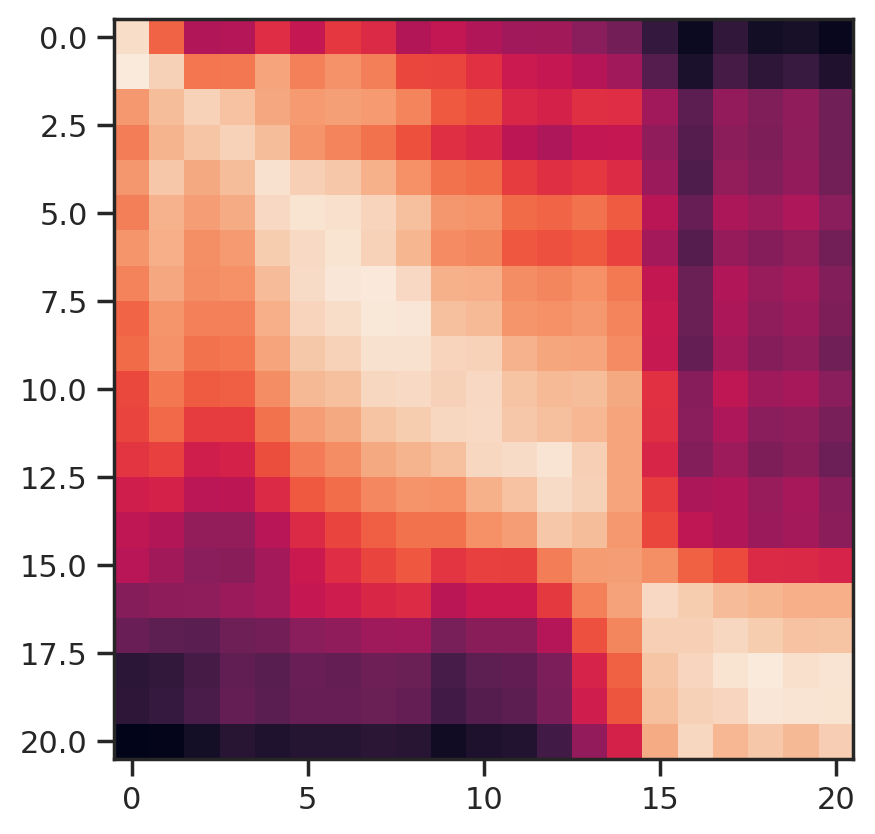

In [ ]:
plt.imshow(sim)

In [ ]:
import numpy as np
hi_simba = np.load('/content/Maps_HI_SIMBA_LH_z=0.00.npy')
hi_tng = np.load('/content/Maps_HI_IllustrisTNG_LH_z=0.00.npy')
hi_simba.shape, hi_tng.shape

((15000, 256, 256), (15000, 256, 256))

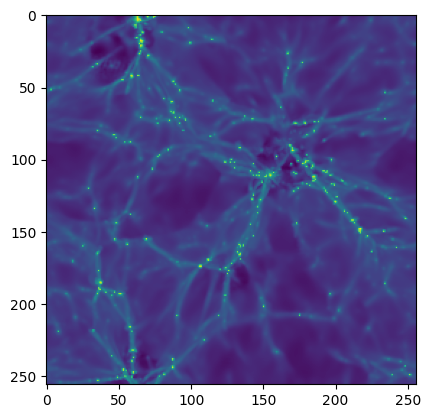

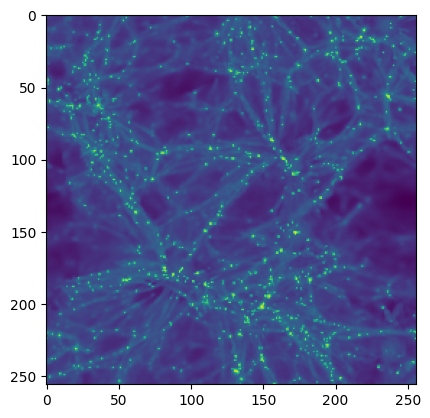

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(np.log(1+hi_simba[0].squeeze())); plt.show()
plt.imshow(np.log(1+hi_tng[0].squeeze())); plt.show()

In [ ]:
fparams = '/content/params_IllustrisTNG.txt'
params = np.loadtxt(fparams)
map_number = 101
params_map = params[map_number//15]
filename = 'HI_tng_100_example_simParams.npy'
np.save(filename, params_map)
shutil.copy(filename, 'drive/MyDrive/CAMELS/CKA_matrices_and_results')

fparams = '/content/params_SIMBA.txt'
params = np.loadtxt(fparams)
map_number = 101
params_map = params[map_number//15]
filename = 'HI_simba_100_example_simParams.npy'
np.save(filename, params_map)

shutil.copy(filename, 'drive/MyDrive/CAMELS/CKA_matrices_and_results')

'drive/MyDrive/CAMELS/CKA_matrices_and_results/HI_simba_100_example_simParams.npy'

In [ ]:
filename = 'HI_simba_100_example.npy'
np.save(filename, hi_simba[100].squeeze())
import shutil
shutil.copy(filename, 'drive/MyDrive/CAMELS/CKA_matrices_and_results')

filename = 'HI_tng_100_example.npy'
np.save(filename, hi_tng[100].squeeze())
import shutil
shutil.copy(filename, 'drive/MyDrive/CAMELS/CKA_matrices_and_results')

'drive/MyDrive/CAMELS/CKA_matrices_and_results/HI_tng_100_example.npy'

<Axes: >

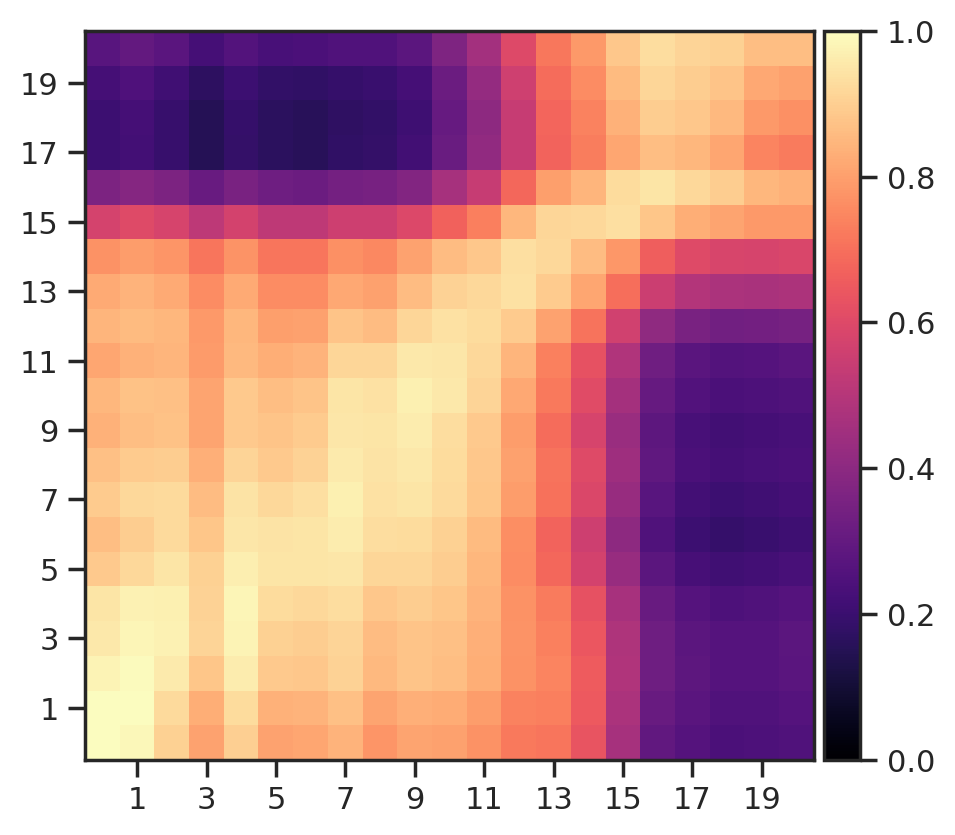

In [ ]:
x=np.load('/content/drive/MyDrive/CAMELS/CKA_matrices_and_results/cka_T_SIMBATrials_appliedOnTNGMaps_16examples.npy')
plot_cka(x)